**MPPI Closed Loop Demo**

# **Installations**

In [ ]:
# Clone the repository
import os
import sys

git_path = '/content/balloon-outreach'
if os.path.exists(git_path):
    print("✅ Found:", git_path)
    sys.path.append('/content/balloon-outreach/')
    %cd balloon-outreach/
else:
    print("❌ Not found:", git_path)
    !git clone https://github.com/sdean-group/balloon-outreach.git
    %cd balloon-outreach
    !git checkout main

Cloning into 'balloon-outreach'...
remote: Enumerating objects: 873, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 873 (delta 130), reused 128 (delta 110), pack-reused 666 (from 1)
Receiving objects: 100% (873/873), 70.79 MiB | 9.88 MiB/s, done.
Resolving deltas: 100% (523/523), done.
/content/balloon-outreach
Already on 'v0'
Your branch is up to date with 'origin/v0'.


In [ ]:
# Install required packages
!pip install -r requirements.txt
!pip install -U gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.7 MB/s eta 0:00:00
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268067 sha256=eff1bc717714be623a33b9ee03203121c785ce5525e4bec815702d97166c93aa
  Stored in directory: /root/.cache/pip/wheels/17/3c/41/2bc89719586c2a5c53e9a527daa76a968a1288315c1ae2d904
Successfully built reverse_geocoder


In [ ]:
from google.colab import drive
import gdown
import os

# 1. Mount your Drive
drive.mount('/content/drive')

# 2. Check existence
if os.path.exists('/content/drive/My Drive/era5_data.nc'):
    print("✅ Found:", '/content/drive/My Drive/era5_data.nc')
    datapath = '/content/drive/My Drive/era5_data.nc'
    
elif os.path.exists("/content/balloon-outreach/era5_data.nc"):
    print("✅ Found:", "/content/balloon-outreach/era5_data.nc")
    datapath = "/content/balloon-outreach/era5_data.nc"

else:
    print("❌ Not found")
    # Download ERA5 data
    file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
    url = f"https://drive.google.com/uc?id={file_id}"
    output = "era5_data.nc"
    gdown.download(url, output, quiet=False)
    datapath = "/content/balloon-outreach/era5_data.nc"


Downloading...
From (original): https://drive.google.com/uc?id=1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf
From (redirected): https://drive.google.com/uc?id=1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf&confirm=t&uuid=c4f97b90-ecee-4025-b955-fd78aa07c3a7
To: /content/balloon-outreach/era5_data.nc
100%|██████████| 1.65G/1.65G [00:17<00:00, 94.0MB/s]


'era5_data.nc'

# **MPPI Optimization Loop Review**

Below is a review of one optimization loop in the MPPI algorithm:

Final control sequence: [ 0.037107    0.06261393  0.03721078  0.01302771 -0.00669915 -0.00074632
  0.00417974 -0.04423569 -0.03362407 -0.02382226]


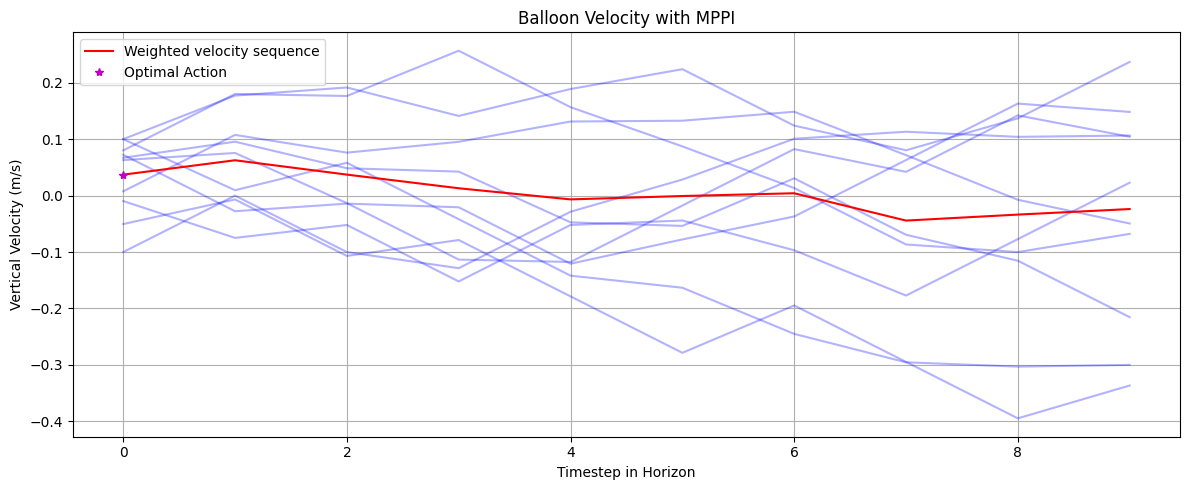

In [ ]:
import os
import sys
import numpy as np

os.chdir('/content/balloon-outreach')
sys.path.append('/content/balloon-outreach')

from script.main_mppi import run_episode
from env.balloon_env import BalloonEnvironment
from agent.mppi_agent import MPPIAgent, MPPIAgentWithCostFunction
import matplotlib.pyplot as plt

initial_lat = 0
initial_lon = 0
initial_alt = 12.0
target_lat = 5
target_lon = 10
target_alt = 12
max_steps = 100
env = BalloonEnvironment(target_lat=target_lat, target_lon=target_lon,target_alt=target_alt)
agent = MPPIAgentWithCostFunction(num_samples=10, acc_bounds=(-0.1,0.1), visualize=False)


horizon = 10
control_sequence = np.zeros(horizon) # our plan of velocities for the balloon


# 1. Sample random control sequences
vertical_velocity = env.balloon.vertical_velocity
base_sequence = control_sequence.copy()
# Add noise to create samples
noise = np.random.normal(0, agent.noise_std, (agent.num_samples, agent.horizon))

acc_samples = base_sequence + noise
acc_samples = np.clip(acc_samples, agent.acc_bounds[0], agent.acc_bounds[1])
accumulated_acc_samples = np.cumsum(acc_samples, axis=1)
vel_samples = vertical_velocity + accumulated_acc_samples

# Clip to action bounds
vel_samples = np.clip(vel_samples, agent.vel_bounds[0], agent.vel_bounds[1])

# 2. Calculate cost of each sequence
costs = []
for i in range(horizon):
    # Evaluate one sample control sequence
    cost = 0.0
    trajectory = []
    vel_sample = vel_samples[i]
    acc_sample = acc_samples[i]

    cost, _ = agent._evaluate_control_sequence(acc_sample,vel_sample, [], env)
    costs.append(cost)

costs = np.array(costs)

# Check for NaN costs and replace with high cost
if np.any(~np.isfinite(costs)):
    print("Warning: NaN costs detected, replacing with high cost")
    costs = np.where(np.isfinite(costs), costs, 1e6)

# 3. Use the costs to calculate weights for each sampled sequence
# Shift costs to prevent numerical issues
costs_shifted = costs - np.min(costs)

# Compute weights using softmax
weights = np.exp(-1 * costs_shifted)
weights = weights / np.sum(weights)

# Check for NaN weights
if np.any(~np.isfinite(weights)):
    print("Warning: NaN weights detected, using uniform weights")
    weights = np.ones_like(weights) / len(weights)

# 4. Compute optimal control sequence by weighted averaging
optimal_sequence = np.average(vel_samples, axis=0, weights=weights)
# Check for NaN in optimal control
if not np.isfinite(optimal_sequence[0]):
    print("Warning: NaN optimal control detected, using zero action")
    optimal_sequence[0] = 0.0

# 5. Update control sequence
control_sequence = optimal_sequence

print(f"Final control sequence: {control_sequence}")

# Plot final velocity
plt.figure(figsize=(12, 5))

for vel_sample in vel_samples:
    plt.plot([i for i in range(horizon)], vel_sample, 'b-', alpha=0.3)
plt.plot([i for i in range(horizon)], control_sequence, 'r-', alpha=1, label='Weighted velocity sequence')
plt.plot(0, control_sequence[0], 'm*', label='Optimal Action')
plt.grid(True)
plt.title(f'Balloon Velocity with MPPI')
plt.xlabel('Timestep in Horizon')
plt.ylabel('Vertical Velocity (m/s)')
plt.legend()

plt.tight_layout()
plt.savefig('velocity.png')
plt.show()
plt.close()



# **Trajectory Demo**

Basic MPPI with Basic WindField:

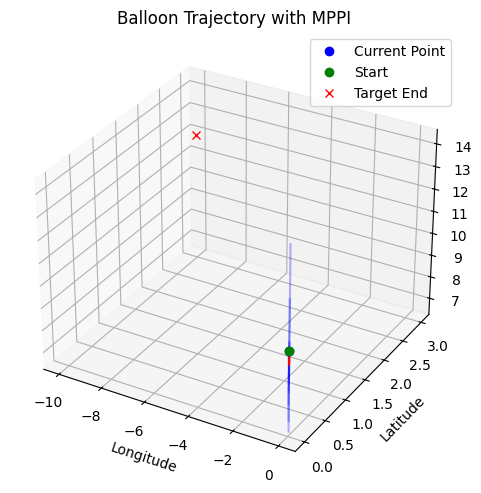

Step 0: lat: 0.00, lon: 0.00, alt: 9.89
Average time to get one action: 5.310344219207764
Average time to take one step: 0.040312767028808594
Average time to get one action: 5.310344219207764


In [ ]:
# Demo without windfield
import os
import sys
import numpy as np

os.chdir('/content/balloon-outreach')
sys.path.append('/content/balloon-outreach')

from script.main_mppi import run_episode
from env.balloon_env import BalloonEnvironment
from agent.mppi_agent import MPPIAgent
import matplotlib.pyplot as plt

initial_lat = 0
initial_lon = 0
initial_alt = 12.0
target_lat = 3
target_lon = -10
target_alt = 12
noise_std = 1
horizon=50
num_samples=10
num_iterations=1
vel_bounds = (-1.0, 1.0)
time_step = 120
objective = 'target'
env = BalloonEnvironment(target_lat=target_lat, target_lon=target_lon,target_alt=target_alt, dt=time_step, objective=objective)
agent = MPPIAgent(horizon=horizon, num_samples=num_samples,num_iterations=num_iterations, vel_bounds=vel_bounds,visualize=True, objective=objective)

reward = run_episode(env, agent, max_steps=1)


MPPI with Cost and ERA WindField:

WindField initialized with noise enabled: True


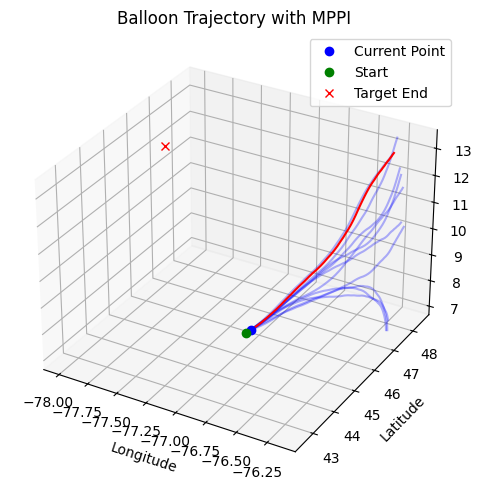

Step 0: lat: 42.77, lon: -76.49, alt: 9.89
Average time to get one action: 3.1340110301971436
Average time to take one step: 0.015725135803222656
Average time to get one action: 3.1340110301971436


In [ ]:
# Demo with windfield and more complex agent
import os
import sys
import numpy as np

os.chdir('/content/balloon-outreach')
sys.path.append('/content/balloon-outreach')

from script.main_mppi import run_episode
from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgentWithCostFunction
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt

 #This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 47
target_lon = -78
target_alt = 12.0
time_step = 120 #120 seconds
max_steps = int(1440/(time_step/60)) #1 day
noise_std = 1
horizon=50
num_samples=10
num_iterations=1
ds = xr.open_dataset("era5_data.nc", engine="netcdf4")
start_time = dt.datetime(2024, 7, 1, 0, 0)
env = BalloonERAEnvironment(ds=ds, start_time=start_time, initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon, dt=time_step, viz=False)
agent = MPPIAgentWithCostFunction(target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)


Example of trajectories after running for a few steps:

WindField initialized with noise enabled: True


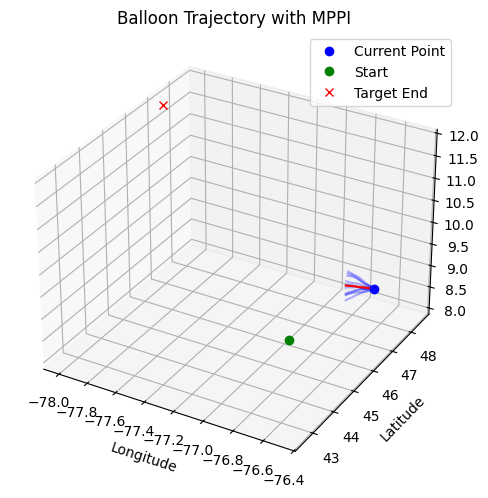

In [8]:
# Demo with more steps - takes a bit longer to run (~1min)
 #This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 47
target_lon = -78
target_alt = 12.0
time_step = 120 #120 seconds
max_steps = int(1440/(time_step/60)) #1 day
noise_std = 1
horizon=10 # reduced horizon for computation time
num_samples=10
num_iterations=1
ds = xr.open_dataset("era5_data.nc", engine="netcdf4")
start_time = dt.datetime(2024, 7, 1, 0, 0)
env = BalloonERAEnvironment(ds=ds, start_time=start_time, initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon, dt=time_step, viz=False)
agent = MPPIAgentWithCostFunction(target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=False, objective='target')


state = env.reset()
for step in range(100):
    # Get action from agent
    action = agent.select_action(state, env, step)
    state, reward, done, info = env.step(action)

    if done:
        print(f"\nEpisode terminated: {info}")
        break
# Visualize next step
agent.visualize=True
action = agent.select_action(state, env, 101)
state, reward, done, info = env.step(action)


The longer we run the agent, the closer it should get to the target. We can see below the agent has made progress from where it started.

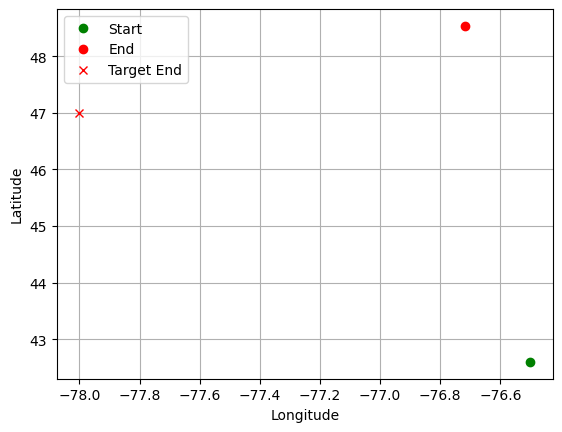

In [9]:
plt.plot(initial_lon, initial_lat, 'go', label='Start')
plt.plot(state[1], state[0], 'ro', label='End')
plt.plot(env.target_lon, env.target_lat, 'rx', label='Target End')
plt.grid(True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

Below is a demo with the fly-as-far objective. Try changing how long the agent runs:

WindField initialized with noise enabled: True


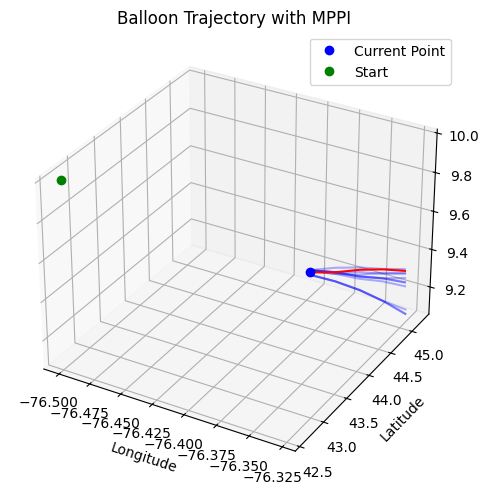

Ended at lat: 44.5108207540644, lon: -76.38058485315315, alt: 9.355443115857376


In [11]:
# Fly as far demo
 #This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 47
target_lon = -78
target_alt = 12.0
time_step = 120 #120 seconds
#max_steps = int(1440/(time_step/60)) #1 day
noise_std = 1
horizon=5 # reduced horizon for computation time
num_samples=10
num_iterations=1
temperature = 1
objective='fly'
ds = xr.open_dataset("era5_data.nc", engine="netcdf4")
start_time = dt.datetime(2024, 7, 1, 0, 0)
env = BalloonERAEnvironment(ds=ds, start_time=start_time, initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon, dt=time_step,objective=objective, viz=False)
agent = MPPIAgentWithCostFunction(num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=False, objective=objective)

max_steps = 10 # explore this to see where balloon ends up!
state = env.reset()
for step in range(max_steps-1):
    # Get action from agent
    action = agent.select_action(state, env, step)
    state, reward, done, info = env.step(action)

    if done:
        print(f"\nEpisode terminated: {info}")
        break
# Visualize next step
agent.visualize=True
action = agent.select_action(state, env, max_steps-1)
state, reward, done, info = env.step(action)
print(f"Ended at lat: {state[0]}, lon: {state[1]}, alt: {state[2]}")

# **Changing Hyperparameters**

With MPPI you can change:

- temperature ($λ$) - sharpness of the weighting
- number of samples ($n$) - variety of trajectories
- standard deviation ($σ$) - determines randomness
- horizon length ($h$) - length of plan to generate
- number of iterations ($i$) - how many times to optimize a plan
- acceleration bounds ($(a_1, a_2)$)

*(We are not changing velocity bounds as that is part of the balloon dynamics, not just the trajectory)*

For each hyperparamaeter, you can modify the values and see how the sampled and final trajectories might change.

In [12]:
# Rerun this cell between each hyperparameter demo
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 47
target_lon = -78
target_alt = 12.0
time_step = 120 #120 seconds
max_steps = int(1440/(time_step/60)) #1 day
acc_bounds = (-0.1, 0.1)
noise_std = 1
horizon=50
num_samples=10
num_iterations=1
temperature=10

*Temperature:*

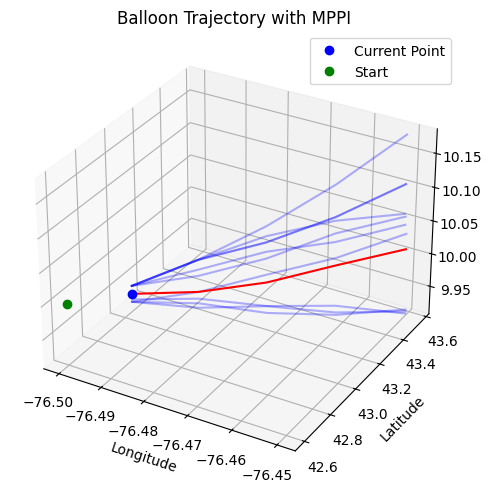

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 0.7775833606719971
Average time to take one step: 0.01894855499267578
Average time to get one action: 0.7775833606719971


In [13]:
env.reset()
agent1 = MPPIAgentWithCostFunction(temperature = 0.01, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

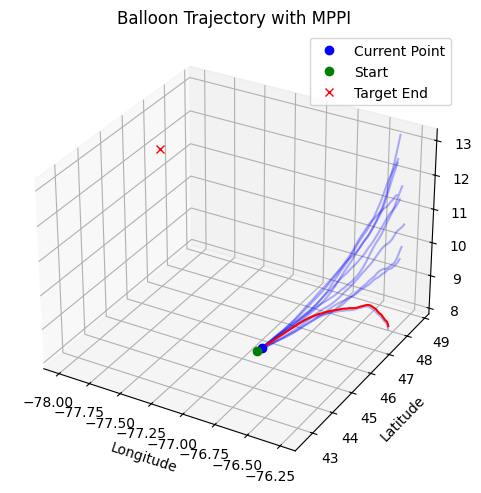

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 3.211625337600708
Average time to take one step: 0.017046213150024414
Average time to get one action: 3.211625337600708


In [14]:
env.reset()
agent = MPPIAgentWithCostFunction(temperature = 100, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Number of samples:*

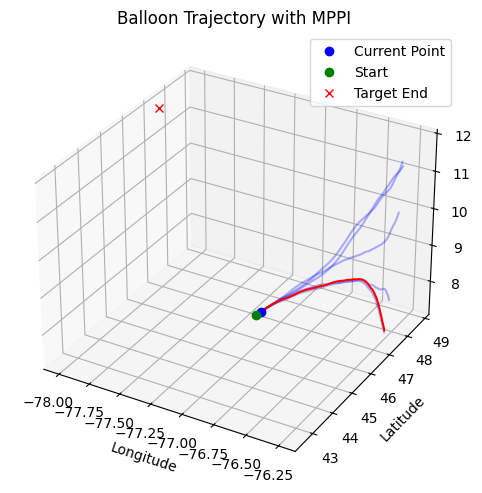

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 2.761204957962036
Average time to take one step: 0.01843738555908203
Average time to get one action: 2.761204957962036


In [15]:
env.reset()
agent = MPPIAgentWithCostFunction(num_samples = 5, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

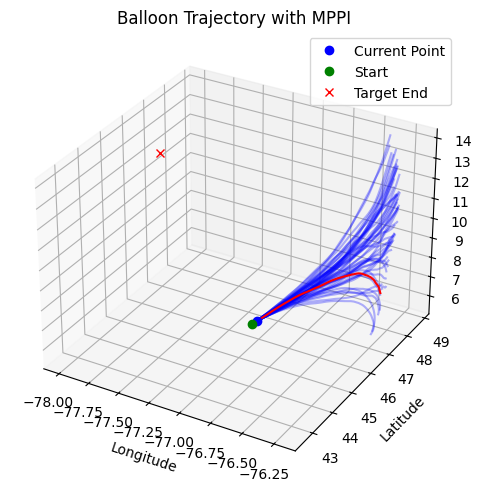

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 14.498641014099121
Average time to take one step: 0.013429641723632812
Average time to get one action: 14.498641014099121


In [16]:
env.reset()
agent = MPPIAgentWithCostFunction(num_samples = 50, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Standard deviation* - this has less of an effect in our environment unless acceleration and velocity are clipped to different ranges. For example, even if std_dev=5, velocity is set to be between -1 to 1 so the samples would mostly be -1 or 1.

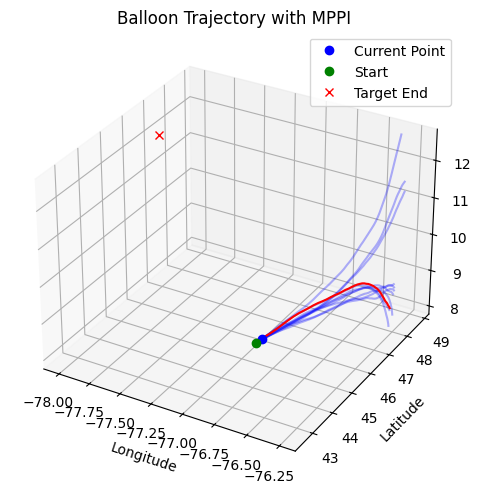

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 3.182182550430298
Average time to take one step: 0.019294261932373047
Average time to get one action: 3.182182550430298


In [17]:
env.reset()
agent = MPPIAgentWithCostFunction(noise_std=0.1, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

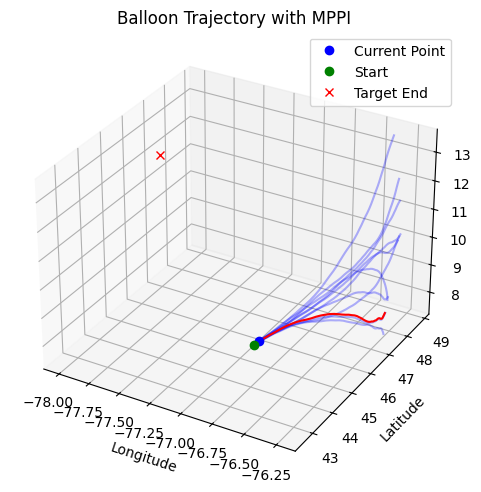

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 3.4190778732299805
Average time to take one step: 0.022142410278320312
Average time to get one action: 3.4190778732299805


In [18]:
env.reset()
agent = MPPIAgentWithCostFunction(noise_std=2, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Horizon length* - having too large of a horizon can compound mistakes in trajectories and increase computation time, but having too small of a horizon doesn't account for long term effects.

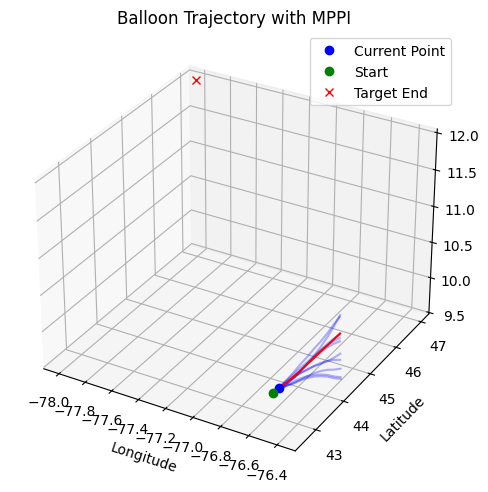

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 1.4384868144989014
Average time to take one step: 0.01657891273498535
Average time to get one action: 1.4384868144989014


In [19]:
env.reset()
agent = MPPIAgentWithCostFunction(horizon=10, noise_std=noise_std, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_iterations=num_iterations,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

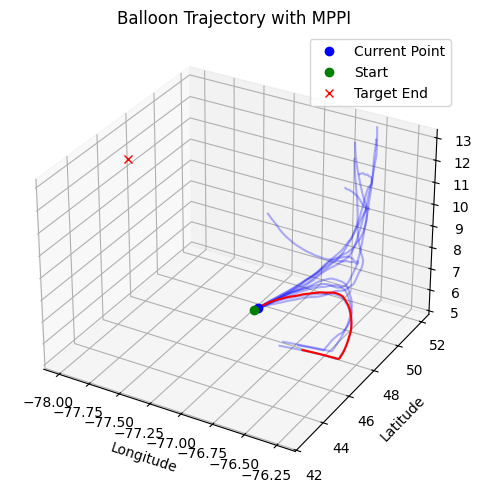

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 5.8249664306640625
Average time to take one step: 0.013391256332397461
Average time to get one action: 5.8249664306640625


In [20]:
env.reset()
agent = MPPIAgentWithCostFunction(horizon=100, noise_std=noise_std, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_iterations=num_iterations,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Number of iterations*

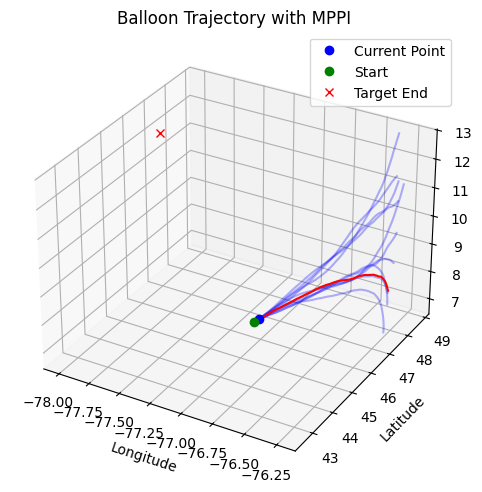

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 3.7531089782714844
Average time to take one step: 0.022112369537353516
Average time to get one action: 3.7531089782714844


In [21]:
env.reset()
agent = MPPIAgentWithCostFunction(num_iterations=1, horizon=horizon, noise_std=noise_std, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

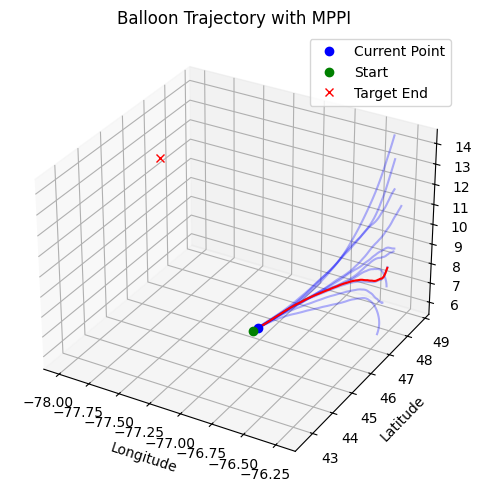

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 3.3064281940460205
Average time to take one step: 0.018886327743530273
Average time to get one action: 3.3064281940460205


In [22]:
env.reset()
agent = MPPIAgentWithCostFunction(num_iterations=30, horizon=horizon, noise_std=noise_std, num_samples = num_samples, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

*Acceleration bounds* - lower bounds allows for smoother control, but slower movement

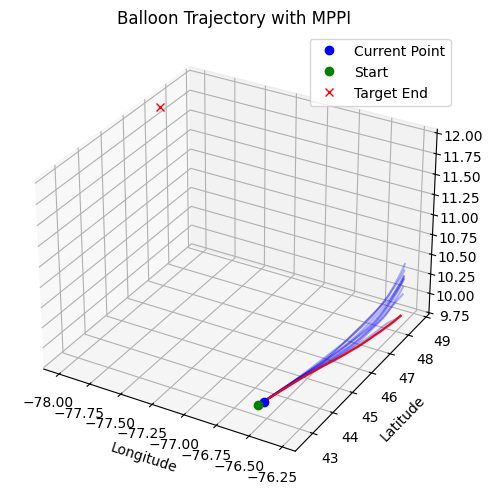

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 3.177767753601074
Average time to take one step: 0.021445035934448242
Average time to get one action: 3.177767753601074


In [23]:
env.reset()
agent = MPPIAgentWithCostFunction(acc_bounds=(-0.01, 0.01), temperature = temperature, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

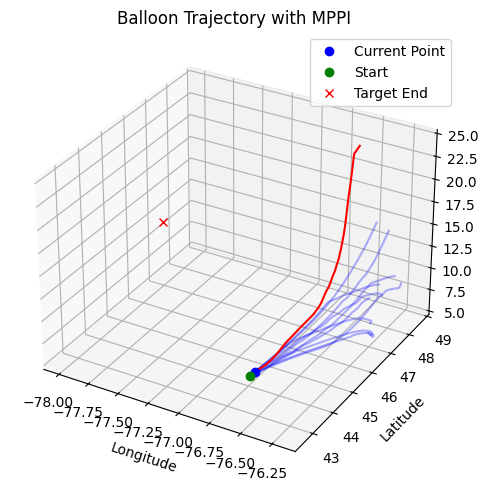

Step 0: lat: 42.78, lon: -76.49, alt: 9.88
Average time to get one action: 4.184603214263916
Average time to take one step: 0.028487443923950195
Average time to get one action: 4.184603214263916


In [24]:
env.reset()
agent = MPPIAgentWithCostFunction(acc_bounds=(-1, 1), temperature = temperature, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

WindField initialized with noise enabled: True


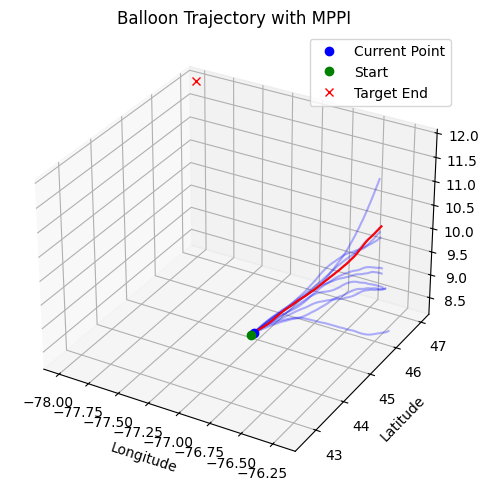

Step 0: lat: 42.68, lon: -76.50, alt: 9.94
Average time to get one action: 3.2989094257354736
Average time to take one step: 0.0122222900390625
Average time to get one action: 3.2989094257354736


In [25]:
env = BalloonERAEnvironment(dt=60,ds=ds, start_time=start_time, initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon, viz=False)
agent = MPPIAgentWithCostFunction(acc_bounds=acc_bounds, temperature = temperature, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)

WindField initialized with noise enabled: True


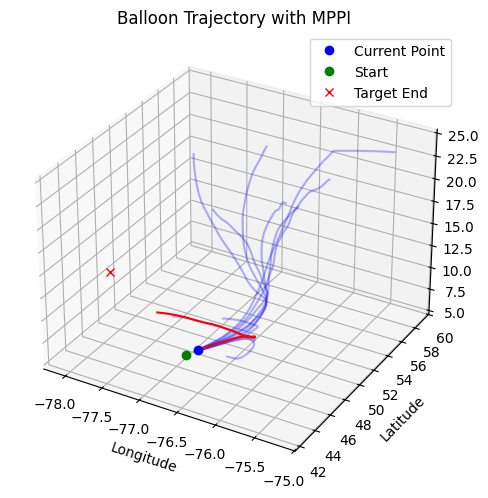

Step 0: lat: 43.48, lon: -76.44, alt: 9.92
Average time to get one action: 2.6895532608032227
Average time to take one step: 0.06660223007202148
Average time to get one action: 2.6895532608032227


In [26]:
env = BalloonERAEnvironment(dt=600,ds=ds, start_time=start_time, initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon, viz=False)
agent = MPPIAgentWithCostFunction(acc_bounds=acc_bounds, temperature = temperature, target_lat=target_lat, target_lon=target_lon, target_alt=target_alt, num_samples=num_samples, noise_std=noise_std, num_iterations=num_iterations, horizon=horizon,visualize=True, objective='target')
reward = run_episode(env, agent, max_steps=1)